# IDL Assignment 0

This notebook contains all the code for the first hand-in for IDL.

Written by Jasper Mens (s2015242) and Laurens Muller in september 2023.


### Task 1: Distance-based classifiers and dimensionality reduction

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# read the MNIST datasets 
traindata = np.loadtxt('train_in.csv', delimiter=',')
trainlabels = np.genfromtxt('train_out.csv', delimiter=',')

testdata = np.genfromtxt('test_in.csv', delimiter=',')
testlabels = np.genfromtxt('test_out.csv', delimiter=',')

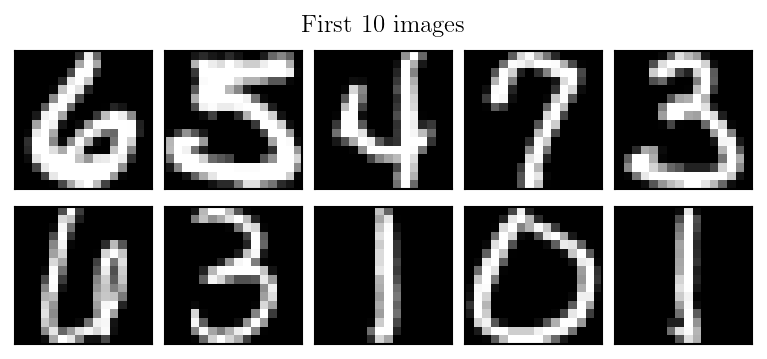

In [24]:
# Preview the first 10 images in the dataset
images = traindata[:11]
labels = trainlabels[:11]
fig, axes = plt.subplots(2,5, figsize=[5,2.3], layout='constrained')


for im, ax, label in zip(images, axes.reshape(1,10)[0], labels):
    ax.imshow(im.reshape(16,16), cmap='binary_r')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_xlabel(int(label))

fig.suptitle("First 10 images")
plt.savefig("reportfigs/firstdigits.pdf")

#### Part 1: point cloud means and distances

In [25]:
# compute the cloud centers
centers = np.zeros((10, 256))

for digit in range(10):
    images = traindata[trainlabels==digit]
    center = np.mean(images, axis=0)
    centers[digit, :] = center

# Plot mean images for each number:
fig, axes = plt.subplots(2,5, figsize=[5,2], layout='constrained')

for im, ax in zip(centers, axes.reshape(1,10)[0]):
    ax.imshow(im.reshape(16,16), cmap='binary_r')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig("reportfigs/meandigits.pdf")
plt.close()

# Plot the distance matrix
distance_matrix = np.zeros((10,10))
for (i,j), _ in np.ndenumerate(distance_matrix):
    distance_matrix[i,j] = np.linalg.norm(centers[i] - centers[j])

# normalize for readability
distance_matrix /= np.max(distance_matrix) 

fig, ax = plt.subplots(1,1, figsize=[5,5], dpi=150, layout='constrained')
ax.imshow(distance_matrix, cmap='viridis')

# Add text labels for ultimate readability
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, round(distance_matrix[i, j],2),
                       ha="center", va="center", color="w")
        
ax.set_xticks(ticks=range(10), labels=range(10))
ax.set_yticks(ticks=range(10), labels=range(10))
plt.savefig("reportfigs/distance_matrix.pdf")
plt.close()

#### Part 2: Dimensionality Reduction

pca-ing
PCA explained variance: [23.56789668 11.26144106]
umapping
tsneing


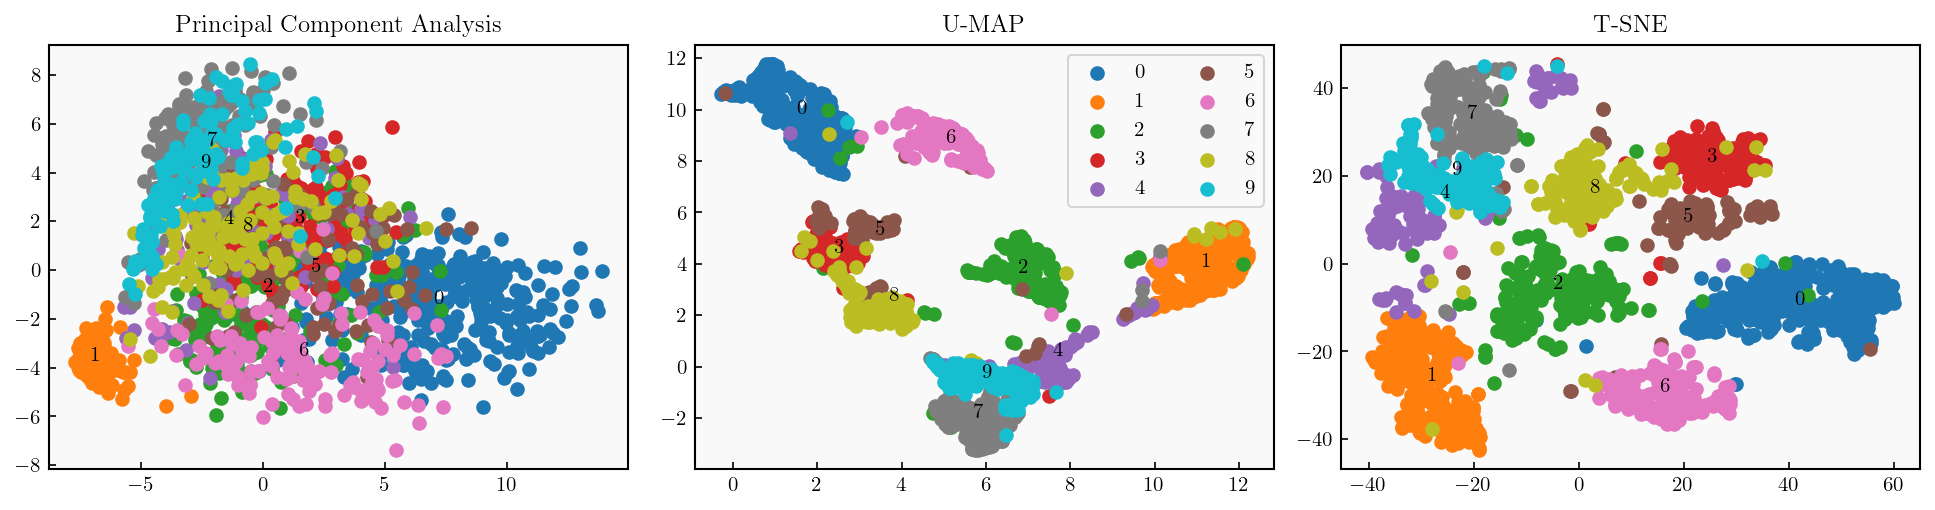

In [26]:
# Make one big figure for all three schemes
fig, (ax_pca, ax_umap, ax_tsne) = plt.subplots(1,3, figsize=[13,3.5], dpi=150, layout='tight')
plt.subplots_adjust(wspace=.1)
ax = ax_pca

# PCA part
from sklearn.decomposition import PCA

print("pca-ing")
pca = PCA(n_components=2)
fit = pca.fit_transform(traindata)
print(f"PCA explained variance: {pca.explained_variance_}")

for digit in range(10):
    plotfit = fit[trainlabels==digit]
    ax.scatter(plotfit[:,0], plotfit[:,1], label=str(digit), )
    ax.text(s=str(digit), x=np.mean(plotfit[:,0]), y=np.mean(plotfit[:,1]),  zorder=10)

ax.set_title("Principal Component Analysis")

# UMAP part
import umap
print("umapping")

ump = umap.UMAP(n_components=2)
fit = ump.fit_transform(traindata)
ax = ax_umap

for digit in range(10):
    plotfit = fit[trainlabels==digit]
    ax.scatter(plotfit[:,0], plotfit[:,1], label=str(digit), )
    ax.text(s=str(digit), x=np.mean(plotfit[:,0]), y=np.mean(plotfit[:,1]),  zorder=10)

ax.legend(ncols=2)
ax.set_title("U-MAP")

# t-SNE part
from sklearn.manifold import TSNE
print("tsneing")
tsne = TSNE(n_components=2)
fit = tsne.fit_transform(traindata)
ax = ax_tsne

for digit in range(10):
    plotfit = fit[trainlabels==digit]
    ax.scatter(plotfit[:,0], plotfit[:,1], label=str(digit), )
    ax.text(s=str(digit), x=np.mean(plotfit[:,0]), y=np.mean(plotfit[:,1]),  zorder=10)

ax.set_title("T-SNE")
plt.savefig("reportfigs/dimreduction.pdf")

#### Part 3: Nearest Mean Classifier

In [27]:
predictions_nmc = np.zeros_like(testlabels)

for i, image in enumerate(testdata):
    # nmc guess is the nearest cloud center
    predictions_nmc[i] = np.argmin([np.linalg.norm(image - center) for center in centers])

correct_ratio = np.count_nonzero(testlabels==predictions_nmc)/len(testlabels)
print(f"correct: {correct_ratio:.2%}")

correct: 80.40%


#### Part 4: KNN classifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_ratio(n_neighbors):
    nbors = KNeighborsClassifier(n_neighbors=n_neighbors)
    nbors.fit(traindata, trainlabels)

    predictions = nbors.predict(testdata)

    return np.count_nonzero(predictions == testlabels)/len(predictions)

# try some values for k to see which one yields the best performance
for n in range(1,10):
    print(f"{n}: {get_ratio(n_neighbors=n):.2%}")


# plot the confusion matrices for the KNNC and NMC
nbors = KNeighborsClassifier(n_neighbors=1)
nbors.fit(traindata, trainlabels)

predictions_knn = nbors.predict(testdata)

cm_nmc = confusion_matrix(testlabels, predictions_nmc, )
cm_knn = confusion_matrix(testlabels, predictions_knn, )

dsp = ConfusionMatrixDisplay(cm_nmc)
dsp.plot()
plt.title("Nearest Mean Classifier (test set)")
plt.savefig("reportfigs/confusion_nmc.pdf")
plt.close()

dsp = ConfusionMatrixDisplay(cm_knn)
dsp.plot()
plt.title("KNN classifier (test set)")
plt.savefig("reportfigs/confusion_knn.pdf")
plt.close()

1: 91.50%
2: 89.80%
3: 91.40%
4: 90.20%
5: 90.80%
6: 90.90%
7: 90.20%
8: 90.20%
9: 89.50%


### Task 2: Single-layer Perceptron

In [29]:
class DigitPerceptron:
    def __init__(self, 
                 traindata, trainlabels, 
                 testdata, testlabels, 
                 random_seed: int = 11,
                 learning_rate: float = .1,
                 ):
        
        self.traindata = traindata
        self.trainlabels = trainlabels
        self.testdata = testdata
        self.testlabels = testlabels
        self.learning_rate = learning_rate

        self.trainmatrix = np.c_[np.ones((len(self.traindata), 1)), self.traindata]
        self.testmatrix = np.c_[np.ones((len(self.testdata), 1)), self.testdata]

        np.random.seed(random_seed)
        self.weights = np.random.random(size=(257,10))

    @property
    def output(self) -> np.array:
        return self.trainmatrix @ self.weights

    @property
    def guesses(self) -> np.array:
        return np.argmax(self.output, axis=1)
    
    @property
    def fraction_correct(self):
        return np.sum(self.guesses == self.trainlabels)/len(self.trainlabels)
    
    @property
    def test_guesses(self):
        test_output = self.testmatrix @ self.weights
        return np.argmax(test_output, axis=1)

    @property
    def test_score(self):
        return np.sum(self.test_guesses == self.testlabels)/len(self.testlabels)
    
    def plot_test_confusion(self):
        confusion = confusion_matrix(self.testlabels, self.test_guesses)
        ConfusionMatrixDisplay(confusion).plot()
        plt.title("Perceptron Confusion (test set)")
        plt.savefig("reportfigs/perceptron_confusion.pdf")
        

    def update_weights(self):
        """Updates the weights once"""
        if np.allclose(self.guesses, self.trainlabels):
            return True

        # pick a misclassified image
        misclassified_image = np.argwhere(self.guesses != self.trainlabels)[0]
        
        # just a little bookkeeping for the next step
        node_activations = self.output[misclassified_image][0]
        correct_digit = self.trainlabels[misclassified_image]
        c_i_activation = node_activations[correct_digit]

        # select which direction to adjust the weights in for each node
        ds = np.zeros((10))
        too_high_nodes = node_activations > c_i_activation
        ds[too_high_nodes] = -1
        ds[correct_digit] = 1

        # apply the weight adjustments
        for digit, d in enumerate(ds):          
            self.weights[:, digit] += d * self.learning_rate * self.trainmatrix[misclassified_image][0]

    def train(self, max_epochs=np.inf):
        """Repeatedly updates the weights until convergence on the training set."""
        epoch = 0
        while not self.update_weights() and epoch < max_epochs:
            print(f"epoch {epoch}: train accuracy {self.fraction_correct:.2%}", end='\r')
            epoch += 1
        print()

        print(f"Test set accuracy: {self.test_score:.2%}")


In [30]:
perceptron1 = DigitPerceptron(traindata = traindata, 
                        trainlabels = trainlabels,
                        testdata = testdata,
                        testlabels = testlabels, 
                        random_seed=1,
                        )

perceptron1.train()

perceptron2 = DigitPerceptron(traindata = traindata, 
                        trainlabels = trainlabels,
                        testdata = testdata,
                        testlabels = testlabels, 
                        random_seed = 2,
                        )

perceptron2.train()

perceptron3 = DigitPerceptron(traindata = traindata, 
                        trainlabels = trainlabels,
                        testdata = testdata,
                        testlabels = testlabels, 
                        random_seed=3,
                        )

perceptron3.train()


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
####################################### Exercise 3 ####################################################
import random
import math
import numpy as np


In [ ]:
def actfun(val):                        # Activation functions
    if actyp == "sigmoid":
        return (1/(1+math.exp(-val)))
    if actyp == "tanh":
        return math.tanh(val)
    if actyp == "relu":
        return max(0,val)

def deractfun(val):
    if actyp == "sigmoid":
        return val*(1-val)
    if actyp == "tanh":
        return 1-val**2
    if actyp == "relu":
        if val >= 0:
            return 1
        else:
            return 0

def activations(weights, input):        # Calculates activations of hidden and output nodes
    net0 = input[0]*weights[0] + input[1]*weights[1] + weights[2]
    y0 = actfun(net0)
    net1 = input[0]*weights[3] + input[1]*weights[4] + weights[5]
    y1 = actfun(net1)
    net = y0*weights[6] + y1*weights[7] + weights[8]
    y = actfun(net)
    return(y0, y1, y)



In [ ]:
############# Exercise 3.1 ##############################
def xor_net(weights, input):            # Returns value of output node
    act = activations(weights, input)
    return act[2]


In [ ]:
################## Exercise 3.2 #########################
def mse(weights, inputs, targets):      # Calculates MSE + number of misclassified inputs
    tot, misit = 0, 0
    for index, input in enumerate(inputs):
        tot += (1/2)*(xor_net(weights, input)-targets[index])**2
        if (targets[index] == 0) and (xor_net(weights,input) > 0.5):    # Outcome > 0.5 is considered 1
            misit += 1
        if (targets[index] == 1) and (xor_net(weights,input) <= 0.5):   # Outcome <= 0.5 is considered 0
            misit += 1
    return tot, misit

In [ ]:
################## Exercise 3.3 ###########################
def grdmse(weights, input, target):    # Output length == input vector weights
    act = activations(weights, input)
    # pw = (act[2]-target)*act[2]*(1-act[2])
    pw = (act[2]-target)*deractfun(act[2]) 
    # pu = (act[2]-target)*act[2]*(1-act[2])*act[0]*(1-act[0])*weights[6]
    pu = (act[2]-target)*deractfun(act[2])*deractfun(act[0])*weights[6]
    # pv = (act[2]-target)*act[2]*(1-act[2])*act[1]*(1-act[1])*weights[7]
    pv = (act[2]-target)*deractfun(act[2])*deractfun(act[1])*weights[7]
    return [pu*input[0], pu*input[1], pu, pv*input[0], pv*input[1], pv, pw*act[0], pw*act[1], pw]

In [ ]:
################## Exercise 3.4 ###################################
def initweights():                      # Random weights initialization
    if inityp == 'uniform':
        return [random.uniform(-1,1) for i in range(9)]
    if inityp == 'normal':
        return [np.random.normal(0,0.2) for i in range(9)]

def gradec(weights, inputs, targets):                       # Gradient descent 
    it = 0
    curmse, misit = mse(weights, inputs, targets)           # Calculate MSE and #misclassified items
    while (curmse > traincut) and (it < trainit):           
        it += 1
        for index, input in enumerate(inputs):
            tgrad = grdmse(weights, input, targets[index])  # Gradient of MSE
            for index1 in range(len(weights)):
                weights[index1] -= eta * tgrad[index1]      # Update rule
        curmse, misit = mse(weights, inputs, targets)
    print("Training complete")
    print("Iterations: ", it, " MSE: ", curmse, " Misclassified: ", misit)
    print("Weights after training: ", weights)
    return

eta = 10                                   # Learning rate
actyp = "sigmoid"                           # Activation function type: sigmoid, tanh or relu
inityp = "uniform"                          # Initialization strategy: normal or uniform
typ = "training"                            # Lazy random trial & error or training
inputs = [[0,0], [1,0], [0,1], [1,1]]       # Training inputs
targets = [0,1,1,0]                         # Training outputs
trainit = 1000                              # Maximum number of training iterations
traincut = 0.1                              # Upper bound for target MSE

if typ == "lazy":
    for i in range(trainit):
        weights = initweights()                         # Weight initialization
        curmse, misit = mse(weights, inputs, targets)   # Calculate MSE and #misclassified items
        print("Iteration ", i,": MSE = ", curmse, " Misclassified inputs: ", misit)
        if curmse < traincut:
            break
else:
    weights = initweights()                         # Weight initialization
    print("Weights before training: ", weights)
    gradec(weights, inputs, targets)

Weights before training:  [-0.7173776388292983, 0.6640639872486238, -0.8912583883523792, 0.7116046005736738, 0.3402046790906432, -0.24165280660248967, -0.38484453168522825, -0.08400670571784086, -0.8616370917508687]
Training complete
Iterations:  150  MSE:  0.07805818266367377  Misclassified:  0
Weights after training:  [-7.242681598610078, 5.232293016092222, -3.7857695182142326, -2.931118764466326, 4.663871248254791, 0.5454989606361624, 5.799674411534954, -4.087413159457457, 1.3351470692432592]
